In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src/transformers')
import os
device_mappings = {0: 1, 1: 5, 2: 6, 3: 7, 4: 2, 5: 3, 6: 0, 7: 4}
os.environ["CUDA_VISIBLE_DEVICES"] = str(device_mappings[7])

import random
import string
from collections import defaultdict, OrderedDict
from itertools import product, chain
import numpy as np
from pattern.en import comparative

import matplotlib.pyplot as plt
import seaborn as sns

from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from enum import Enum
from typing import List, Optional, Union

from child_frames import frames
from utils import *

import logging
import os
import sys

from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed
from transformers import PreTrainedModel, RobertaForMaskedLM, RobertaTokenizer
from transformers.modeling_roberta import RobertaForProbing, RobertaDoubleHeadsModel, \
    RobertaDoubleHeadsModel2, RobertaDoubleHeadsModel3, RobertaForSequenceClassification  # XD
from transformers.trainer import get_mean_pred_prob  # XD

logging.basicConfig(level=logging.ERROR)

In [4]:
A_template = "{rel_prefix} {dt} {ent0} {rel} {dt} {ent1} {rel_suffix}"
B_template = "{pred_prefix} {dt} {ent} {pred}"
entailment_templates = ["{A} ? {conj} , {B} .", "{A} , so {B} ? {conj} .", '"{A}" {conj} "{B}" .', "{A} .||| {B} .|||{conj}"]

markers = {'lexical': '*', 'entity': '#'}
ans2verb = {'Right': 'means', 'Wrong': 'contradicts', 'Maybe': ','}
ans2label = {'Right': 'e', 'Wrong': 'c', 'Maybe': 'n'}

def convert_conj(conj): return ans2verb[conj]
def extract_rel_id(s): return int(s[s.index(':') + 1])
def extract_rel(s): return [t.split(':')[0] for t in s.split() if ':' in t][0]
def strip_rel_id(s, lexical_rel=''):
    rel_id_span = s[s.index(':'): s.index(':') + 2]
    if lexical_rel != '': lexical_rel = ' ( ' + lexical_rel + ' )'
    return s.replace(rel_id_span, lexical_rel)
        
relation_labels = {'entity': ['former', 'latter'], 'lexical': ['same', 'opposite', 'unrelated']}

def make_sentences(entities=['_X', '_Z'], entity_set=string.ascii_uppercase, determiner="",
                   relation_group=[["confident",], ["uncertain",]], rand_relation_group=[["short"], ["tall", "high"]],
                   relation_prefix="", relation_suffix="", predicate_prefix="",
                   n_entity_trials=3, has_negA=True, has_negB=True, has_neutral=False, mask_types={'sent_rel'}, 
                   lexical_relations=None, entity_relations=None, tag_lexical_rel=False, tag_entity_rel=False):
#     if tag_lexical_rel: mask_types.add('lexical_rel')
#     if tag_entity_rel: mask_types.add('entity_rel')
    def get_comparative(word):
        compar = comparative(word)
        if tag_lexical_rel:
            marker = markers['lexical']
            compar = compar.replace('more ', 'more %s ' % marker) if compar.startswith('more ') else marker + ' ' + compar
        return compar
  
    def form_As(relations):
        return [A_template.format(dt=determiner, ent0=ent0, ent1=ent1, rel=rel, 
                                  rel_prefix=relation_prefix, rel_suffix=relation_suffix)
              for ent0, ent1, rel in [entities + relations[:1], reverse(entities) + reverse(relations)[:1]]]
    As = []
    for rel0 in relation_group[0]:
        for rel1 in relation_group[1]:
            relations = ["is %s:%d than" % (get_comparative(rel), i) for i, rel in enumerate([rel0, rel1])]
            As += form_As(relations)
    As = list(set(As))
    negAs = join_lists([negate_sent(A)[:1] for A in As]) if has_negA else []

    def form_Bs(predicates): 
        f = mask if 'entity' in mask_types else (lambda x: x)
        return [B_template.format(dt=determiner, ent=f(ent), pred=pred, pred_prefix=predicate_prefix)
              for ent, pred in zip(entities, predicates)]

    Bs, negBs = {'orig': [], 'rand': []}, {}
    for k, group in zip(['orig', 'rand'], [relation_group, rand_relation_group]):
        for rel0 in group[0]:
            for rel1 in group[1]:
                predicates = ["is %s:%d" % (get_comparative(rel), i) for i, rel in enumerate([rel0, rel1])]
                Bs[k] += form_Bs(predicates)
    for k in Bs:
        Bs[k] = list(set(Bs[k]))
        if has_negB:
            negBs[k] = join_lists([negate_sent(B)[:1] for B in Bs[k]])
            Bs[k], negBs[k] = Bs[k] + [swap_entities(negB) for negB in negBs[k]], negBs[k] + [swap_entities(B) for B in Bs[k]]
        else:
            negBs[k] = [swap_entities(B) for B in Bs[k]]
      
    comparatives = [comparative(r).replace('more ', '') for r in join_lists(relation_group) + join_lists(rand_relation_group)]
    def form_sentences(sentence_template, As, Bs, conj):
        def compare_and_tag_comparative(A, B):
            if 'Maybe' in conj:
                lexical_rel = 'unrelated'
            else:
                lexical_rel = 'same' if extract_rel_id(A) == extract_rel_id(B) else 'opposite'
            if lexical_relations and lexical_rel not in lexical_relations:
                return None, None
            if 'lexical_rel' in mask_types: lexical_rel = mask(lexical_rel)
            return strip_rel_id(A), strip_rel_id(B, lexical_rel)
        def tag_entity(token, recurred_entity, entity_rel=None):
            if token != recurred_entity: return token
            return markers['entity'] + ' ' + token
#             if token not in entities: return token
#             entity_rel = 'paired' if token == recurred_entity else 'single'
#             if 'entity_rel' in mask_types: entity_rel = mask(entity_rel)
#             return token + ' ( %s )' % entity_rel
        def compare_and_tag_entity(A, B):
            recurred_entity = [e for e in entities if e in B.split()][0]
            A = ' '.join([tag_entity(token, recurred_entity) for token in A.split()])
            B = ' '.join([tag_entity(token, recurred_entity) for token in B.split()])
            entity_rel = 'former' if A.split().index(recurred_entity) in [0, 1] else 'latter'
            if entity_relations and entity_rel not in entity_relations: return None, None
            if 'entity_rel' in mask_types: entity_rel = mask(entity_rel)
            return A, B.replace(recurred_entity, recurred_entity + ' ( ' + entity_rel + ' )')
        
        if '?' not in sentence_template:
            conj = ans2label[conj] if sentence_template.count('|||') == 2 else ans2verb[conj]
        if 'sent_rel' in mask_types and conj not in ans2label.values(): conj = mask(conj)
        sentences = []
        cores = []
        for A, B in product(As, Bs):
            A, B = compare_and_tag_comparative(A, B) \
                if tag_lexical_rel else (strip_rel_id(A), strip_rel_id(B))
            if A is None: continue
            if tag_entity_rel: A, B = compare_and_tag_entity(A, B)
            if A is None: continue
            sent = sentence_template.format(A=A, B=B, conj=conj)
            sent = " " + " ".join(sent.split())
            sentences.append(sent)
        return sentences, cores
    
    sentences = defaultdict(list)
    cores = defaultdict(list)
    for entailment_template in entailment_templates[-1:]:
        for A, B, conj in [(As, Bs['orig'], 'Right'), (negAs, negBs['orig'], 'Right'), 
                           (As, negBs['orig'], 'Wrong'), (negAs, Bs['orig'], 'Wrong'),
                           (As, Bs['rand'], 'Maybe'), (negAs, negBs['rand'], 'Maybe'), 
                           (As, negBs['rand'], 'Maybe'), (negAs, Bs['rand'], 'Maybe')]:
            ss, cs = form_sentences(entailment_template, A, B, conj)
            sentences[conj] += ss
            cores[conj] += cs
    assert len(sentences['Right']) == len(sentences['Wrong']), \
        '%d %d' % (len(sentences['Right']), len(sentences['Wrong']))
    if has_neutral:
        sentences['Maybe'] = random.sample(sentences['Maybe'], len(sentences['Right']))
    keys = sentences.keys() if has_neutral else ['Right', 'Wrong']
    sentences = join_lists(sentences[k] for k in keys)
    
    def substitute(templates, n_entity_trials):
        substituted_groups = []
        for template in templates:
            group = []
            for _ in range(n_entity_trials):
                e0, e1 = random.sample(entity_set, 2)
                group.append(template.replace(entities[0], e0).replace(entities[1], e1))
            substituted_groups.append(group)
        return substituted_groups
    
    substituted_sent_groups = substitute(sentences, n_entity_trials=n_entity_trials)
    cores = list(set(join_lists(cores[k] for k in keys)))
    cores = balance(cores, relation_labels)
    substituted_core_groups = substitute(cores, n_entity_trials=1)
    return sentences, substituted_sent_groups #, cores, substituted_core_groups

make_sentences(has_negA=True, has_negB=True, has_neutral=False, tag_lexical_rel=False, tag_entity_rel=False,
               mask_types={'sent_rel'})[0]

[' _X is more confident than _Z .||| _X is more confident .|||e',
 ' _X is more confident than _Z .||| _Z is more uncertain .|||e',
 ' _X is more confident than _Z .||| _Z is less confident .|||e',
 ' _X is more confident than _Z .||| _X is less uncertain .|||e',
 ' _Z is more uncertain than _X .||| _X is more confident .|||e',
 ' _Z is more uncertain than _X .||| _Z is more uncertain .|||e',
 ' _Z is more uncertain than _X .||| _Z is less confident .|||e',
 ' _Z is more uncertain than _X .||| _X is less uncertain .|||e',
 ' _X is less confident than _Z .||| _X is less confident .|||e',
 ' _X is less confident than _Z .||| _Z is less uncertain .|||e',
 ' _X is less confident than _Z .||| _Z is more confident .|||e',
 ' _X is less confident than _Z .||| _X is more uncertain .|||e',
 ' _Z is less uncertain than _X .||| _X is less confident .|||e',
 ' _Z is less uncertain than _X .||| _Z is less uncertain .|||e',
 ' _Z is less uncertain than _X .||| _Z is more confident .|||e',
 ' _Z is l

In [5]:
P_template = '{ent0} {rel} {ent1}'
# transitive_template = '{p0} and {p1} , so {Q} ? {conj} .'
transitive_template = '{p0} and {p1} .||| {Q} .|||{conj}'
transitive_wh_QA_template = '{which} is {pred} ? {ent} .'

def make_transitive(entities=["_X", "_Y", "_Z"], entity_set=string.ascii_uppercase,
                    relation_group=[["big", ], ["small", ]], n_entity_trials=3,
                    has_negA=True, has_negB=True, has_neutral=False, mask_types=['sent_rel'],
                    tag_lexical_rel=False, tag_entity_rel=False):
    has_negP, has_negQ = has_negA, has_negB
    def get_comparative(word): return comparative(word)
    def form_atoms(relations, entities, has_neg=True):
        atoms = [P_template.format(ent0=ent0, ent1=ent1, rel=rel) for ent0, ent1, rel in
                 [entities + relations[:1], reverse(entities) + reverse(relations)[:1]]]
        if has_neg:
            neg_rels = [r.replace('is ', 'is not ') for r in relations]
            atoms += [P_template.format(ent0=ent0, ent1=ent1, rel=rel) for ent0, ent1, rel in
                      [entities + reverse(neg_rels)[:1], reverse(entities) + neg_rels[:1]]]
        return atoms

    def form_sentences(sentence_template, Ps, Qs, conj):
        sentences = []
        if '?' not in sentence_template:
            conj = ans2label[conj] if sentence_template.count('|||') == 2 else ans2verb[conj]
        if 'sent_rel' in mask_types and conj not in ans2label.values(): conj = mask(conj)
        for (p0, p1), Q in product(Ps, Qs):
            sent = sentence_template.format(p0=strip_rel_id(p0), p1=strip_rel_id(p1),
                                              Q=strip_rel_id(Q), conj=conj)
            sent = " " + " ".join(sent.split())
            sentences.append(sent)
        return sentences

    def form_all(P0_entities, P1_entities, Q_entities, neutral=False):
        P0, P1 = [], []
        for rel0 in relation_group[0]:
            for rel1 in relation_group[1]:
                relations = ["is %s:%d than" % (get_comparative(rel), i)
                             for i, rel in enumerate([rel0, rel1])]
                P0 += form_atoms(relations, P0_entities, has_neg=has_negP)
                P1 += form_atoms(relations, P1_entities, has_neg=has_negP)
        Ps = [(p0, p1) for p0, p1 in list(product(P0, P1)) + list(product(P1, P0))]

        Qs = form_atoms(relations, Q_entities, has_neg=has_negQ)
        negQs = [swap_entities(Q, *Q_entities) for Q in Qs]

        for P, Q, conj in [(Ps, Qs, 'Right'), (Ps, negQs, 'Wrong')]:
            if neutral: conj = 'Maybe'
            sentences[conj] += form_sentences(transitive_template, P, Q, conj)
        return sentences

    e0, e1, e2 = entities
    sentences = defaultdict(list)
    form_all(P0_entities=[e0, e1], P1_entities=[e1, e2], Q_entities=[e0, e2])
    assert len(sentences['Right']) == len(sentences['Wrong']), \
        '%d %d' % (len(sentences['Right']), len(sentences['Wrong']))
    sample_ratio = len(relation_group[0]) * len(relation_group[1])
    if sample_ratio > 1:
        for key in sentences:
            sentences[key] = random.sample(sentences[key], len(sentences[key]) // sample_ratio)
#     print('nRight =', len(sentences['Right']))
    if has_neutral:
        form_all(P0_entities=[e0, e1], P1_entities=[e0, e2], Q_entities=[e1, e2], neutral=True)
        sentences['Maybe'] = random.sample(sentences['Maybe'], len(sentences['Right']))
    keys = sentences.keys() if has_neutral else ['Right', 'Wrong']
    sentences = join_lists(sentences[k] for k in keys)

    substituted_sent_groups = []
    for sent in sentences:
        sent_group = []
        for _ in range(n_entity_trials):
            e0, e1, e2 = random.sample(entity_set, 3)
            sent_group.append(sent.replace(entities[0], e0)
                              .replace(entities[1], e1)
                              .replace(entities[2], e2))
        substituted_sent_groups.append(sent_group)
    return sentences, substituted_sent_groups

make_transitive(has_negA=True, has_negB=True, has_neutral=True)[0]

[' _X is bigger than _Y and _Y is bigger than _Z .||| _X is bigger than _Z .|||e',
 ' _X is bigger than _Y and _Y is bigger than _Z .||| _Z is smaller than _X .|||e',
 ' _X is bigger than _Y and _Y is bigger than _Z .||| _X is not smaller than _Z .|||e',
 ' _X is bigger than _Y and _Y is bigger than _Z .||| _Z is not bigger than _X .|||e',
 ' _X is bigger than _Y and _Z is smaller than _Y .||| _X is bigger than _Z .|||e',
 ' _X is bigger than _Y and _Z is smaller than _Y .||| _Z is smaller than _X .|||e',
 ' _X is bigger than _Y and _Z is smaller than _Y .||| _X is not smaller than _Z .|||e',
 ' _X is bigger than _Y and _Z is smaller than _Y .||| _Z is not bigger than _X .|||e',
 ' _X is bigger than _Y and _Y is not smaller than _Z .||| _X is bigger than _Z .|||e',
 ' _X is bigger than _Y and _Y is not smaller than _Z .||| _Z is smaller than _X .|||e',
 ' _X is bigger than _Y and _Y is not smaller than _Z .||| _X is not smaller than _Z .|||e',
 ' _X is bigger than _Y and _Y is not smal

In [6]:
tokenizer_class, shortcut = RobertaTokenizer, 'roberta-base'
tokenizer = tokenizer_class.from_pretrained(shortcut)

In [7]:
## rand_relation_group=_frames[(i + 1) % len(_frames)], 
random.seed(42)
random.shuffle(frames)
entity_set = list(string.ascii_uppercase)
random.shuffle(entity_set)
split_pct = [0.7, 0.3]

In [8]:
tag2id = {'same': 0, 'opposite': 1, 'unrelated': 2, 'former': 0, 'latter': 1, 'another': 5, 'single': 6, 'paired': 7}
tag2id = {'Ġ' + k: v for k, v in tag2id.items()}
id2tag = {v: k for k, v in tag2id.items()}

n_entity_trials = 3
kwargs = {'n_entity_trials': n_entity_trials, 'has_neutral': True, 'has_negA': True, 'has_negB': True, 
          'tag_lexical_rel': False, 'tag_entity_rel': False, 'mask_types': {'sent_rel',}}
train_lines, eval_lines = [[make_transitive(relation_group=rg, entity_set=_ent_set, **kwargs)[1] for i, rg in enumerate(_frames)]
                           for _frames, _ent_set in zip(split(frames, split_pct), split(entity_set, split_pct))]
random.sample(flatten(train_lines), 10)
# all_lines = [make_transitive(relation_group=rg, n_entity_trials=n_entity_trials,
#                              has_negP=True, has_negQ=True, has_neutral=True, mask_types=['sent_rel'])[1]
#              for i, rg in enumerate(frames)]
# all_lines = join_lists(all_lines)
# all_lines = join_lists(all_lines)
tokenizer.tag2id, tokenizer.id2tag = tag2id, id2tag
# for k in CHILDDataset.all_lines: CHILDDataset.all_lines[k] = None
kwargs = {'has_tags': False, 'max_noise_len': 0, 'n_replicas': 1}
train_dataset = CHILDDataset(train_lines, tokenizer, mode='train', **kwargs)
eval_dataset = CHILDDataset(eval_lines, tokenizer, mode='dev', **kwargs)
print('nTrain = %d, nValid = %d' % (len(train_dataset), len(eval_dataset)))

[' D is more conventional than R and D is more conventional than V .||| V is more conventional than R .|||n',
 ' V is more unfamiliar than X and V is more familiar than D .||| D is not stranger than X .|||c',
 ' Y is not more ignorant than X and I is not more knowledgeable than X .||| I is not more knowledgeable than Y .|||e',
 ' E is more unprepared than T and C is not more unprepared than T .||| E is more unprepared than C .|||e',
 ' T is more unaffected than E and T is more affected than A .||| A is more affected than E .|||c',
 ' V is more benevolent than B and V is more vicious than O .||| O is not more benevolent than B .|||c',
 ' X is not more faded than N and N is not more neutral than C .||| C is not more colorful than X .|||e',
 ' J is stranger than F and F is stranger than D .||| D is more familiar than J .|||e',
 ' Y is quicker than V and O is not slower than V .||| O is not slower than Y .|||n',
 ' I is not more manual than J and I is not more automatic than R .||| J is no

nTrain = 118656, nValid = 10000


In [ ]:
model = RobertaForSequenceClassification.from_pretrained("ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli")
# model = RobertaForSequenceClassification.from_pretrained("roberta-large-mnli")
# model_class = RobertaForMaskedLM
# # model_class = RobertaForProbing
# model = model_class.from_pretrained('roberta-base', state_dict=state_dict)
steps = max(int(round(100 * n_entity_trials / 3)), int(len(train_dataset) / 32 / 4))
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=32, per_device_eval_batch_size=64,
    learning_rate=2e-5, num_train_epochs=3,
    logging_steps=steps, eval_steps=steps, save_steps=0,
    no_cuda=False, evaluate_during_training=True,
)
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset)
trainer.tokenizer = tokenizer
model.tokenizer = tokenizer
trainer.train()

loading state_dict took 2.817 sec



{'eval_loss': 1.421565, 'eval_acc_0': 0.394, 'eval_stat_0': '<s> 0.32 0.68, <pad> 0.09 0.51, </s> 0.58 0.71, ', 'epoch': 0, 'step': 0}


{'loss': 0.121083, 'learning_rate': 1.8333333333333333e-05, 'epoch': 0.25, 'step': 927}



{'eval_loss': 0.620081, 'eval_acc_0': 0.933, 'eval_stat_0': '<s> 0.33 1.00, <pad> 0.34 1.00, </s> 0.33 1.00, ', 'epoch': 0.25, 'step': 927}
{'loss': 0.036956, 'learning_rate': 1.6666666666666667e-05, 'epoch': 0.5, 'step': 1854}



{'eval_loss': 0.138495, 'eval_acc_0': 0.98, 'eval_stat_0': '<s> 0.33 1.00, <pad> 0.33 1.00, </s> 0.34 1.00, ', 'epoch': 0.5, 'step': 1854}


In [ ]:
 6  0.51/0.51  0.51/0.51  0.51/0.52  0.51/0.52  0.57/0.53  0.51/0.52  0.60/0.54  0.51/0.51  0.51/0.51  0.53/0.51  0.60/0.54  0.51/0.52  
 7  0.52/0.51  0.51/0.54  0.61/0.52  0.54/0.51  0.51/0.55  0.52/0.52  0.51/0.51  0.51/0.52  0.51/0.52  0.53/0.51  0.65/0.55  0.62/0.54  
 8  0.51/0.52  0.51/0.52  0.58/0.51  0.59/0.52  0.51/0.51  0.51/0.51  0.54/0.52  0.51/0.51  0.51/0.51  0.51/0.53  0.51/0.52  0.51/0.52 

In [ ]:
lexical_rel per_layer
 0  0.60/0.53  0.61/0.52  0.50/0.51  0.51/0.51  0.50/0.52  0.49/0.51  
 1  0.70/0.55  0.58/0.54  0.51/0.52  0.51/0.51  0.51/0.51  0.51/0.52  
 2  0.64/0.54  0.62/0.60  0.51/0.52  0.51/0.52  0.52/0.52  0.52/0.51  
 3  0.82/0.64  0.74/0.60  0.51/0.52  0.51/0.52  0.54/0.52  0.55/0.51  
 4  0.72/0.56  0.77/0.58  0.51/0.52  0.51/0.52  0.62/0.53  0.60/0.52  
 5  0.82/0.68  0.83/0.70  0.51/0.52  0.51/0.52  0.60/0.54  0.59/0.52  
 6  0.72/0.66  0.73/0.67  0.51/0.52  0.51/0.52  0.65/0.59  0.60/0.52  
 7  0.71/0.58  0.73/0.59  0.51/0.52  0.51/0.52  0.68/0.61  0.67/0.54  
 8  0.77/0.56  0.75/0.58  0.51/0.52  0.56/0.53  0.59/0.54  0.72/0.53  
 9  0.60/0.55  0.78/0.55  0.51/0.52  0.50/0.52  0.52/0.53  0.53/0.53  
10  0.70/0.56  0.67/0.57  0.52/0.51  0.51/0.52  0.61/0.52  0.57/0.53  
11  0.71/0.58  0.74/0.62  0.55/0.52  0.56/0.52  0.68/0.54  0.56/0.53 

In [ ]:
lexical_rel cumulative
 0  0.52/0.57  0.54/0.55  0.51/0.51  0.51/0.51  0.53/0.52  0.54/0.51  
 1  0.63/0.55  0.58/0.56  0.51/0.51  0.51/0.51  0.51/0.52  0.53/0.51  
 2  0.62/0.55  0.65/0.66  0.51/0.51  0.51/0.52  0.54/0.52  0.54/0.51  
 3  0.78/0.64  0.71/0.71  0.51/0.52  0.51/0.52  0.57/0.52  0.55/0.51  
 4  0.82/0.66  0.74/0.72  0.51/0.52  0.51/0.52  0.64/0.53  0.57/0.52  
 5  0.86/0.75  0.79/0.77  0.51/0.52  0.51/0.52  0.66/0.54  0.67/0.52  
 6  0.84/0.75  0.81/0.79  0.51/0.51  0.51/0.52  0.67/0.62  0.67/0.52  
 7  0.84/0.72  0.82/0.78  0.51/0.52  0.51/0.51  0.69/0.65  0.72/0.53  
 8  0.83/0.71  0.80/0.76  0.51/0.52  0.51/0.52  0.67/0.64  0.73/0.54  
 9  0.80/0.67  0.77/0.73  0.51/0.52  0.51/0.52  0.65/0.61  0.66/0.53  
10  0.75/0.66  0.76/0.71  0.51/0.51  0.51/0.52  0.63/0.59  0.67/0.53  
11  0.69/0.60  0.70/0.63  0.51/0.52  0.51/0.52  0.60/0.54  0.56/0.52 

In [ ]:
entity_rel per_layer
 0  1.00/0.94  0.97/0.59  0.47/0.51  0.50/0.51  0.50/0.51  0.49/0.51  
 1  1.00/0.95  1.00/0.77  0.53/0.50  0.85/0.52  1.00/0.68  0.63/0.51  
 2  1.00/0.97  1.00/0.90  0.50/0.50  0.80/0.51  0.91/0.58  0.90/0.51  
 3  1.00/0.92  1.00/0.85  0.51/0.50  0.73/0.50  0.97/0.58  0.94/0.55  
 4  1.00/0.92  1.00/0.89  0.99/0.51  0.55/0.50  1.00/0.74  1.00/0.62  
 5  1.00/0.95  1.00/0.96  0.97/0.50  0.93/0.51  1.00/0.86  0.99/0.60  
 6  1.00/0.97  1.00/0.95  0.96/0.51  0.97/0.51  1.00/0.94  0.98/0.76  
 7  1.00/0.96  1.00/0.95  0.78/0.56  0.78/0.53  1.00/0.96  0.98/0.84  
 8  1.00/0.95  1.00/0.91  0.87/0.74  0.91/0.79  1.00/0.92  1.00/0.93  
 9  1.00/0.92  0.99/0.84  0.87/0.71  0.86/0.73  0.99/0.84  0.99/0.88  
10  1.00/0.89  0.95/0.79  0.82/0.71  0.84/0.71  0.96/0.81  0.97/0.85  
11  1.00/0.88  0.99/0.83  0.82/0.74  0.84/0.76  0.97/0.89  0.87/0.79  

In [ ]:
0  1.00/0.98  1.00/0.90  0.51/0.51  0.51/0.51  0.48/0.51  0.50/0.51  
1  1.00/0.98  1.00/0.90  0.51/0.50  0.58/0.51  0.99/0.61  0.59/0.51  
2  1.00/0.98  1.00/0.91  0.52/0.50  0.76/0.51  0.97/0.61  0.70/0.52  
3  1.00/0.98  1.00/0.94  0.53/0.50  0.57/0.50  0.91/0.59  0.86/0.52  
4  1.00/0.98  1.00/0.95  0.51/0.50  0.52/0.50  0.94/0.59  0.90/0.53  
5  1.00/0.98  1.00/0.95  0.87/0.50  0.50/0.50  0.96/0.60  0.97/0.56  
6  1.00/0.98  1.00/0.95  0.92/0.50  0.50/0.50  0.81/0.67  0.96/0.58  
7  1.00/0.98  1.00/0.93  0.80/0.51  0.50/0.51  0.88/0.68  0.86/0.57  
8  1.00/0.97  1.00/0.90  0.83/0.50  0.73/0.52  0.83/0.65  0.92/0.56  
9  1.00/0.96  1.00/0.86  0.75/0.51  0.72/0.53  0.82/0.62  0.89/0.57  
10  1.00/0.95  1.00/0.83  0.75/0.51  0.73/0.52  0.78/0.60  0.89/0.57  
11  0.99/0.84  0.98/0.68  0.65/0.52  0.64/0.52  0.74/0.56  0.80/0.56 

In [11]:
output_dir = '/nas/xd/data/models/CHILD/neg0_ent3/'
# os.makedirs(output_dir, exist_ok=True)
# model.save_pretrained(output_dir)

In [12]:
state_dict = torch.load(output_dir + 'pytorch_model.bin')

In [72]:
# model = RobertaForMaskedLM.from_pretrained('roberta-base')
model = RobertaForMaskedLM.from_pretrained(output_dir)
_ = model.to(trainer.args.device)

loading state_dict took 4.104 sec


In [80]:
model.roberta.selectively_masked_head = (5, 5)

In [185]:
dataloader = DataLoader(
    eval_dataset,
    sampler=RandomSampler(eval_dataset),
    batch_size=1 or trainer.args.eval_batch_size,
    collate_fn=trainer.data_collator,
    drop_last=trainer.args.dataloader_drop_last,
)

In [186]:
for inputs in dataloader: break

for i in range(20):
    if i < len(inputs['input_ids']):
        print(i, tokenizer.decode(inputs['input_ids'][i]), 
              [tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])[j] for j in inputs['marked_pos_labels'][i][0]])
inputs = trainer._prepare_inputs(inputs, model)

0 <s> S is further than G, so G is further?<mask>.</s><pad><pad><pad><pad><pad> ['Ġfurther', 'Ġfurther']


In [159]:
_ = model.eval()
interpretable_embedding = configure_interpretable_embedding_layer(model, 'roberta.embeddings')

inputs = trainer._prepare_inputs(inputs, model)
input_ids, attention_mask, token_type_ids, position_ids, labels = \
    inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids'], inputs['position_ids'], inputs['labels']
additional_fwd_args = (token_type_ids, position_ids, attention_mask)
if 'marked_pos_labels' in inputs and inputs['marked_pos_labels'] is not None:
    marked_pos_labels = inputs['marked_pos_labels']
    marked_positions = marked_pos_labels[:, 0]  # (bsz, 1, 2) -> (bsz, 2)
    cls_positions = (input_ids == model.tokenizer.cls_token_id).nonzero()[:, 1:]
    sep_positions = (input_ids == model.tokenizer.sep_token_id).nonzero()[:, 1:]
    be_positions = torch.ones_like(cls_positions) * 2
    mask_positions = (input_ids == model.tokenizer.mask_token_id).nonzero()[:, 1:]
    assert cls_positions.size(0) == sep_positions.size(0) == mask_positions.size(0) == marked_positions.size(0), \
        '%d %d %d %d' % (cls_positions.size(0), sep_positions.size(0), mask_positions.size(0), marked_positions.size(0))
#     probe_positions = mask_positions
    probe_positions = torch.cat([cls_positions, sep_positions, be_positions, mask_positions], dim=-1)
    additional_fwd_args = additional_fwd_args + (marked_pos_labels, probe_positions)
additional_fwd_args = additional_fwd_args + (labels,)
input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
all_tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(input_ids[0]))

In [164]:
# def mlm_fwd_fn(inputs, token_type_ids=None, position_ids=None, attention_mask=None, labels=None, mask_id=None):
def mlm_fwd_fn(inputs, *args):
    args, labels, mask_id = args[:-2], args[-2], args[-1]
    is_probe_logits = True
    logits = model(inputs, *args, detach=False)[int(is_probe_logits)]
    if not is_probe_logits:
        bsz, seq_len, vocab_size = logits.size()
        logits = logits[labels != -100].view(bsz, -1, vocab_size)
    return logits[:, mask_id].max(dim=-1).values

mask_id = 0
layer_attrs = []
n_layers = 7 + mask_id or model.config.num_hidden_layers
model.zero_grad()
for i in range(n_layers):
    lc = LayerIntegratedGradients(mlm_fwd_fn, model.roberta.encoder.layer[i])
    attributions = lc.attribute(inputs=input_embeddings, 
                                additional_forward_args=additional_fwd_args + (mask_id,), 
                                n_steps=20)[0]
    layer_attrs.append(summarize_attributions(attributions).cpu().detach().tolist())

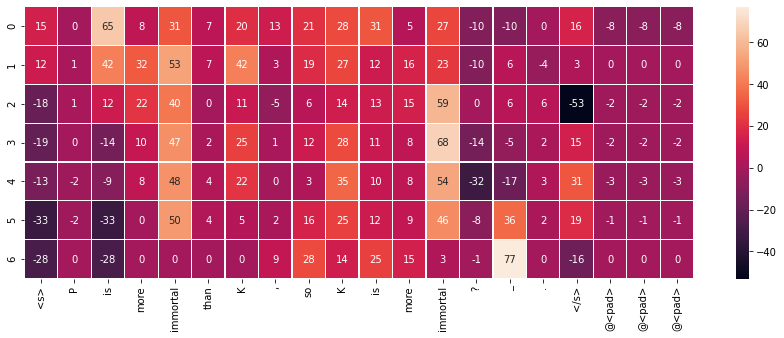

In [165]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(n_layers))
ax = sns.heatmap((np.array(layer_attrs) * 100).astype('int64'), xticklabels=xticklabels, yticklabels=yticklabels, annot=True, fmt='d', linewidth=0.2)
# plt.xlabel('Tokens')
# plt.ylabel('Layers')
plt.show()

In [167]:
remove_interpretable_embedding_layer(model, interpretable_embedding)

In [227]:
_ = model.eval()
model.zero_grad()
# with torch.no_grad():
_, logits, probe_logits, all_attentions = model(**inputs, output_attentions=True, detach=False)[:4]
attn_probs = all_attentions  # torch.stack(all_attentions, dim=0).cpu()

In [228]:
base_layer, layer = 6, 6
H, bsz = 12, probe_logits.size(0)
tc_labels = inputs['tc_labels'][inputs['tc_labels'] != -100]
so_token_id, mask_token_id = tokenizer._convert_token_to_id('Ġso'), tokenizer.mask_token_id
pos = (inputs['input_ids'] == so_token_id).nonzero()[:, 1].item()
tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))
attn_probs[layer].retain_grad()
probe_logits[torch.arange(bsz), (layer - base_layer) * H: (layer - base_layer + 1) * H, tc_labels].mean().backward()

0.8664488792419434

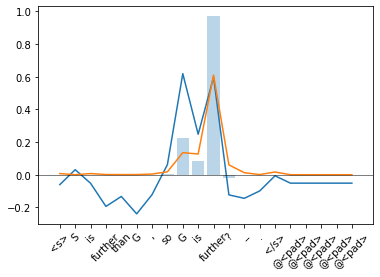

In [229]:
head = 6
ga = attn_probs[layer].grad[:, head][0, pos]
a = attn_probs[layer][:, head][0, pos]
nn.Softmax(dim=-1)(probe_logits)[torch.arange(bsz), (layer - base_layer) * H + head, tc_labels].item()

_ = plt.plot(normalize(ga.cpu()))
_ = plt.plot(a.detach().cpu())
_ = plt.bar(range(len(tokens)), normalize((ga * a.detach()).cpu()), alpha=0.3)
_ = plt.axhline(y=0, linewidth=0.5, color='k')
_ = plt.xticks(range(len(tokens)), tokens, rotation=45)

0.5935156941413879

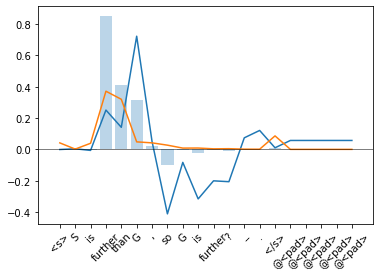

In [220]:
head = 10
ga = attn_probs[layer].grad[:, head][0, pos]
a = attn_probs[layer][:, head][0, pos]
nn.Softmax(dim=-1)(probe_logits)[torch.arange(bsz), (layer - base_layer) * H + head, tc_labels].item()

_ = plt.plot(normalize(ga.cpu()))
_ = plt.plot(a.detach().cpu())
_ = plt.bar(range(len(tokens)), normalize((ga * a.detach()).cpu()), alpha=0.3)
_ = plt.axhline(y=0, linewidth=0.5, color='k')
_ = plt.xticks(range(len(tokens)), tokens, rotation=45)

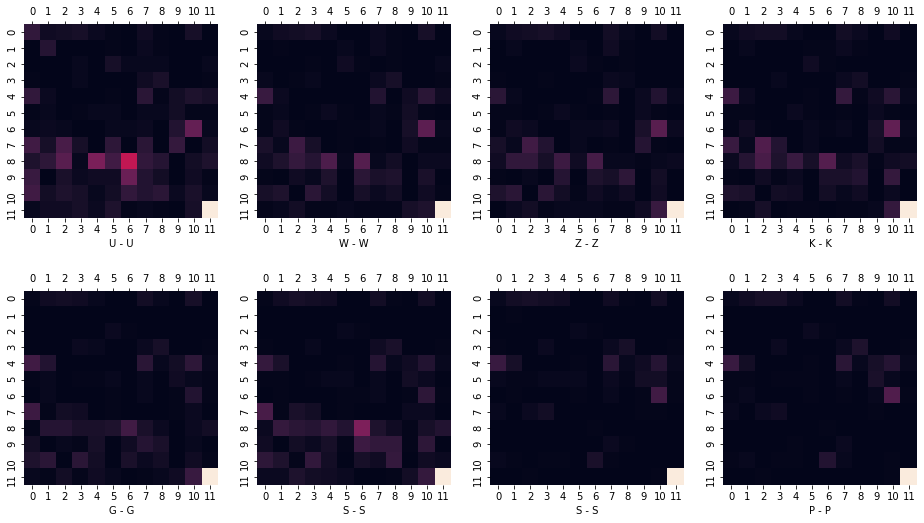

In [406]:
sample_indices = [[0, 1, 2, 3], 
                  [4, 5, 6, 7]]
# sample_indices = [[0, 0], 
#                   [0, 0]]
n_rows, n_cols = len(sample_indices), len(sample_indices[0])
fig, axs = plt.subplots(n_rows, n_cols, sharey=False, figsize=(4 * n_cols, 4.5 * n_rows))
sep_id = tokenizer._convert_token_to_id('Ġ,')
for row in range(n_rows):
    for col in range(n_cols):
        i, ax = sample_indices[row][col], axs[row][col]
        tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][i]))
        
        p, h = inputs['marked_pos_labels'][i][0]
        p, h = p.item(), h.item()
        so_pos = (inputs['input_ids'][i] == tokenizer._convert_token_to_id('Ġso')).nonzero()[0, 0].item()
        be2_pos = so_pos + 2
        mask_pos = (inputs['input_ids'][i] == tokenizer.mask_token_id).nonzero()[0, 0].item()
#         j = 17
        pos_attn = attn_probs[:, i, :, mask_pos, h]
        pos_attn[-1, -1] = 1.
        ax = sns.heatmap((pos_attn * 100).long(), square=True, cbar=False, annot=False, fmt='d', ax=ax)
        ax.tick_params(top=True, labeltop=True)
        _ = ax.set_xlabel('%s - %s' % (tokens[p], tokens[h]))

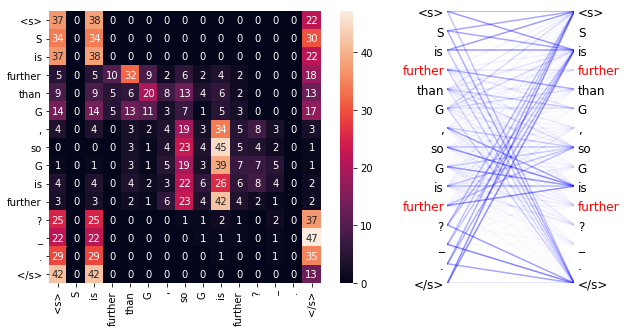

In [209]:
i = 0
layer, head = 7, 10
seq_len = inputs['attention_mask'][i].sum().item()
attn =  attn_probs[layer][i, head, : seq_len, : seq_len]
tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])[: seq_len])
size = round(attn.size(0) / 3)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(size  * 2., size), gridspec_kw={'width_ratios': [3, 1]})
_ = sns.heatmap((attn * 100).long().cpu(), square=True, cbar=True, annot=True, fmt='d', xticklabels=tokens, yticklabels=tokens, ax=ax0)
plot_head_attn(attn, tokens, ax1=ax1, marked_positions=inputs['marked_pos_labels'][i])

H5-8, H6-4, H7-6(+1), H7-10: ,/so/is/more -> h_ent  
H8-6: ?/mask -> so

H6-6: ,/so/is/more -> h  
H6-10: ,/so/is/more -> p  
H7-9: ?/mask -> so

In [ ]:
#         pos_attn = attn_probs[:, i]
#         pos_attn = pos_attn * (pos_attn > 0.3)
# #         pos_attn[0] = 0  # layer 0
# #         pos_attn[1, 1] = 0  # ->pos-2
#         pos_attn = pos_attn.mean(dim=(0, 1))
#         input_ids = inputs['input_ids'][i]
#         sep_pos = (input_ids == sep_id).nonzero()[0].item()
#         segment_ids = torch.zeros_like(input_ids)
#         segment_ids[sep_pos + 1:] = 1
#         segment_mask = segment_ids.unsqueeze(0) != segment_ids.unsqueeze(1)
#         pos_attn = pos_attn * segment_mask.cpu()
#         seq_len = inputs['attention_mask'][i].sum().item()
#         pos_attn[:, [0, 2, seq_len - 1]] = 0
#         k = torch.arange(1, pos_attn.size(0) - 1)
#         pos_attn[k, k] = 0
#         pos_attn[k, k - 1] = 0
#         pos_attn[k, k + 1] = 0
#         ax = sns.heatmap((pos_attn * 100).long(), square=True, cbar=False, annot=False, fmt='d', 
#                          xticklabels=tokens, yticklabels=tokens, ax=ax)

In [231]:
length = 4
range_vec = torch.arange(length)
range_mat = range_vec.unsqueeze(-1).expand(-1, length).transpose(0, 1)
distance_mat = range_mat - range_mat.transpose(0, 1)

In [232]:
range_vec

tensor([0, 1, 2, 3])

In [233]:
range_mat

tensor([[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]])

In [234]:
distance_mat

tensor([[ 0,  1,  2,  3],
        [-1,  0,  1,  2],
        [-2, -1,  0,  1],
        [-3, -2, -1,  0]])

In [238]:
max_relative_positions = 2

In [239]:
distance_mat_clipped = torch.clamp(distance_mat,
                                   min=-max_relative_positions,
                                   max=max_relative_positions)

In [240]:
distance_mat_clipped

tensor([[ 0,  1,  2,  2],
        [-1,  0,  1,  2],
        [-2, -1,  0,  1],
        [-2, -2, -1,  0]])

In [241]:
final_mat = distance_mat_clipped + max_relative_positions

In [242]:
final_mat

tensor([[2, 3, 4, 4],
        [1, 2, 3, 4],
        [0, 1, 2, 3],
        [0, 0, 1, 2]])

In [243]:
torch.arange(-length + 1, 1, 1).unsqueeze(0)

tensor([[-3, -2, -1,  0]])